<a href="https://colab.research.google.com/github/helveticacode/TSP/blob/main/tsp_workbook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#モジュールのimport
import urllib.request
import pandas as pd
import matplotlib.pyplot as plt
!pip install simanneal
from simanneal import Annealer
import numpy as np
from scipy.spatial import distance
import random
from google.colab import drive
drive.mount('/content/drive')
from decimal import *
import inspect
import math
import openpyxl
!pip install xlrd
#inspect.getsource(Annealer)
#inspect.getsource(distance)

Mounted at /content/drive


In [ ]:
def att_distance(a,b): #aとbの間のatt距離を返す　a = [x_a,y_a] b = [x_b,y_b]
  xd = a[0] - b[0];
  yd = a[1] - b[1];
  def nint(a):
    b = int(a+0.5)
    return b
  rij = math.sqrt( (xd*xd + yd*yd) / 10.0 );
  tij = nint(rij)
  if tij<rij :
    dij = tij + 1;
  else:
    dij = tij;

  return dij

In [ ]:
def tsp_solve(towns_filename,distance_mesure,ideal_route,move_method = "2-opt",initial_method= "greedy"):


      # town -> 0 Long->1 Lati ->2
  towns_data = pd.read_csv('/content/drive/My Drive/colab/'+towns_filename+'.tsp', header=5,dtype={'Longitude': float, 'Latitude': float})
  df = towns_data['NODE_COORD_SECTION'].str.split(' ', expand=True)

  towns_data = df.rename(columns={0: 'Town',1: 'Longitude',2: 'Latitude'})
  gyo = len(towns_data)


  towns_data = towns_data.astype({'Latitude': float,"Longitude":float})

  for i in range(gyo):
    #print(towns_data['Longitude'][i])
    if math.isnan(towns_data['Longitude'][i]) is True:
          towns_data = towns_data.drop(i)
    elif math.isnan(towns_data['Latitude'][i]) is True:
          towns_data = towns_data.drop(i)


  plt.figure(figsize=(10, 10))
  plt.scatter(towns_data['Latitude'], towns_data['Longitude'])
  for city, x, y in zip(towns_data['Town'], towns_data['Latitude'], towns_data['Longitude']):
      plt.text(x, y, city, alpha=0.5, size=12)
  plt.grid()


  class TravellingSalesmanProblem(Annealer):

      """Test annealer with a travelling salesman problem.
      """

      # pass extra data (the distance matrix) into the constructor
      def __init__(self, state, distance_matrix):
          self.distance_matrix = distance_matrix
          super(TravellingSalesmanProblem, self).__init__(state)  # important! 親クラスの__initが使える

      def move(self):

          if move_method == "2-opt":
            """2-opt"""
            # no efficiency gain, just proof of concept
            # demonstrates returning the delta energy (optional)
            initial_energy = self.energy()

            a = random.randint(0, len(self.state) - 1)
            b = random.randint(0, len(self.state) - 1)
            if a >= b:
              bsave = b
              b = a
              a = bsave
            #これでa<=bになった
            while a<b:
              self.state[a], self.state[b] = self.state[b], self.state[a]
              a = a+1
              b = b-1

            return self.energy() - initial_energy

          elif move_method == "random":
            initial_energy = self.energy()
            a = random.randint(0, len(self.state) - 1)
            b = random.randint(0, len(self.state) - 1)
            self.state[a], self.state[b] = self.state[b], self.state[a]

            return self.energy() - initial_energy

      def energy(self):
          """Calculates the length of the route."""
          e = 0
          for i in range(len(self.state)):
              e += self.distance_matrix[self.state[i-1]][self.state[i]]
          return e



  mat = towns_data[['Latitude', 'Longitude']].values
  mat

  #dist_mat = distance.cdist(mat, mat, metric='euclidean') # ユークリッド距離

  distance_matrix = {}
  for i, town in enumerate(towns_data['Town']):
      if town not in distance_matrix.keys():
          distance_matrix[town] = {}
          a =[towns_data['Longitude'][i],towns_data['Latitude'][i]]
      for j, town2 in enumerate(towns_data['Town']):
          b =[towns_data['Longitude'][j],towns_data['Latitude'][j]]
          distance_matrix[town][town2] = distance_mesure(a,b)
  """
  init_state = list(_data['Town'])
  random.shuffle(init_state)
  """

  states = list(towns_data['Town'])
  init_state = []

  def initial_energy(state):
      """Calculates the length of the route."""
      e = 0
      for i in range(len(state)):
          e += distance_matrix[state[i-1]][state[i]]
      return e

  if initial_method == "greedy":

    len_states = len(states)
    start_townname = states[0]
    init_state.append(start_townname)

    town_keys = []
    now_key = 0   #スタート地点のkey
    calls = []
    for i in range(len_states):
      town_keys.append(i)

    town_keys.remove(now_key)
    calls.append(now_key)
    for _ in range(len_states-1):
      short_distance = 10000000000000000000000000
      """-------find min distance near city--------------"""
      for city in town_keys:
        if city not in calls:
          distance = distance_matrix[towns_data['Town'][now_key]][towns_data['Town'][city]]
          if distance < short_distance:
            short_distance = distance
            save_point = city
      """-----------------------"""
      now_key = save_point
      init_state.append(towns_data['Town'][save_point])
      town_keys.remove(save_point)
      calls.append(save_point)

  if initial_method == "random":
    random.shuffle(init_state)

  plt.figure(figsize=(10, 10))
  Xs = []
  Ys = []
  for i in range(len(init_state)):
      Xs.append(list(towns_data[towns_data['Town'] == init_state[i]].iloc[:, 2])[0])
      Ys.append(list(towns_data[towns_data['Town'] == init_state[i]].iloc[:, 1])[0])

  plt.plot(Xs, Ys)
  for city, x, y in zip(towns_data['Town'], towns_data['Latitude'], towns_data['Longitude']):
      plt.text(x, y, city, alpha=0.5, size=12)

  initial_e = initial_energy(init_state)
  print("initial energy is "+str(initial_e))
  #distance_matrix

  tsp = TravellingSalesmanProblem(init_state, distance_matrix)

  tsp.set_schedule(tsp.auto(minutes=0.2))
  tsp.copy_strategy = "slice"
  state, e = tsp.anneal()

  while state[0] != '1':
          state = state[1:] + state[:1]  # rotate NYC to start

  print()
  print("%i mile route:" % e)
  print(" ➞  ".join(state))
  mistake = e*100/ideal_route - 100
  print("mistake is"+str(mistake))

  plt.figure(figsize=(10, 10))
  Xs = []
  Ys = []
  for i in range(len(state)):
      Xs.append(list(towns_data[towns_data['Town'] == state[i]].iloc[:, 2])[0])
      Ys.append(list(towns_data[towns_data['Town'] == state[i]].iloc[:, 1])[0])

  plt.plot(Xs, Ys)
  for city, x, y in zip(towns_data['Town'], towns_data['Latitude'], towns_data['Longitude']):
      plt.text(x, y, city, alpha=0.5, size=12)

  print("energy of the anneal route is "+str(e)+", energy of the initial route is "+str(initial_e))

  initial_route = initial_e
  result = e
  return [towns_filename,ideal_route,distance_mesure.__name__,move_method,initial_method,initial_route,result]

 Temperature        Energy    Accept   Improve     Elapsed   Remaining


initial energy is 35516


 Temperature        Energy    Accept   Improve     Elapsed   Remaining



38355 mile route:
1 ➞  2 ➞  7 ➞  9 ➞  11 ➞  12 ➞  15 ➞  16 ➞  5 ➞  19 ➞  3 ➞  4 ➞  31 ➞  21 ➞  27 ➞  40 ➞  58 ➞  70 ➞  84 ➞  80 ➞  111 ➞  105 ➞  107 ➞  89 ➞  75 ➞  73 ➞  67 ➞  91 ➞  109 ➞  86 ➞  78 ➞  135 ➞  166 ➞  156 ➞  134 ➞  119 ➞  110 ➞  102 ➞  118 ➞  129 ➞  141 ➞  140 ➞  150 ➞  151 ➞  161 ➞  168 ➞  193 ➞  215 ➞  206 ➞  275 ➞  283 ➞  309 ➞  322 ➞  315 ➞  233 ➞  247 ➞  253 ➞  267 ➞  260 ➞  287 ➞  325 ➞  346 ➞  405 ➞  391 ➞  381 ➞  373 ➞  382 ➞  392 ➞  417 ➞  430 ➞  424 ➞  427 ➞  420 ➞  426 ➞  423 ➞  402 ➞  404 ➞  397 ➞  403 ➞  408 ➞  399 ➞  414 ➞  438 ➞  439 ➞  436 ➞  444 ➞  460 ➞  451 ➞  434 ➞  448 ➞  453 ➞  429 ➞  425 ➞  409 ➞  413 ➞  416 ➞  415 ➞  387 ➞  358 ➞  342 ➞  306 ➞  307 ➞  304 ➞  297 ➞  288 ➞  276 ➞  263 ➞  272 ➞  264 ➞  237 ➞  255 ➞  280 ➞  310 ➞  291 ➞  231 ➞  221 ➞  210 ➞  178 ➞  191 ➞  180 ➞  189 ➞  153 ➞  149 ➞  158 ➞  138 ➞  148 ➞  155 ➞  130 ➞  144 ➞  145 ➞  164 ➞  163 ➞  185 ➞  196 ➞  211 ➞  219 ➞  225 ➞  230 ➞  203 ➞  216 ➞  242 ➞  218 ➞  236 ➞  259 ➞  252 ➞  

NameError: ignored

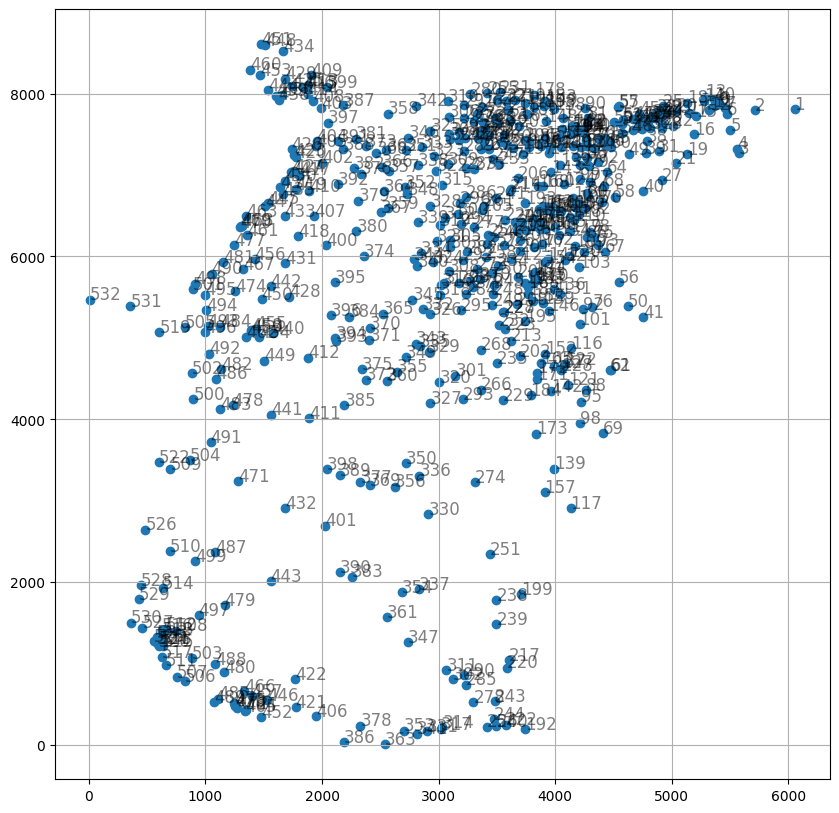

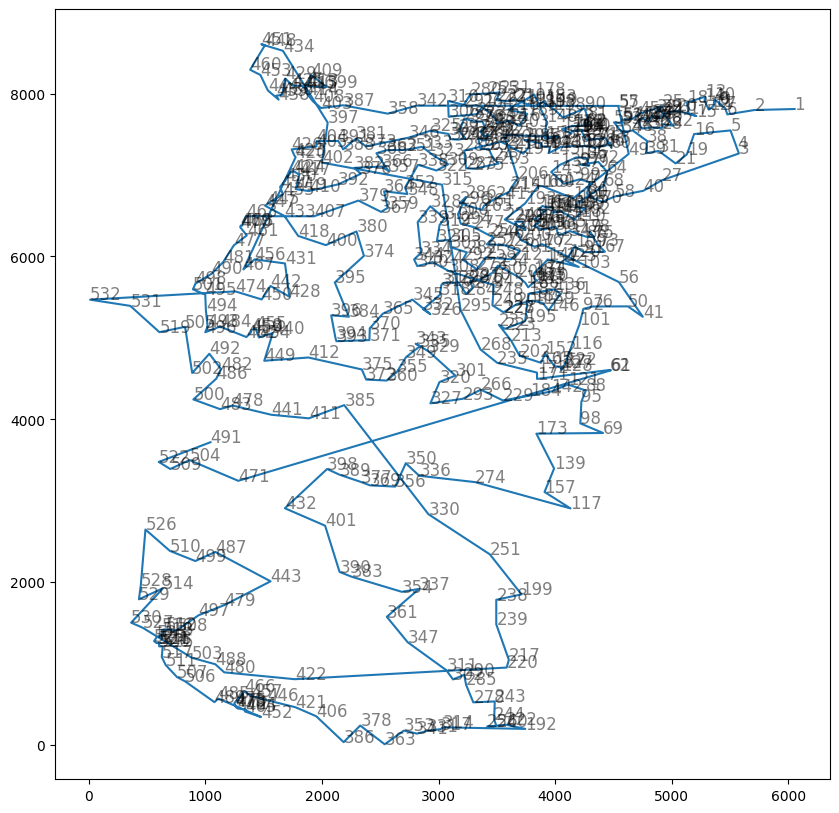

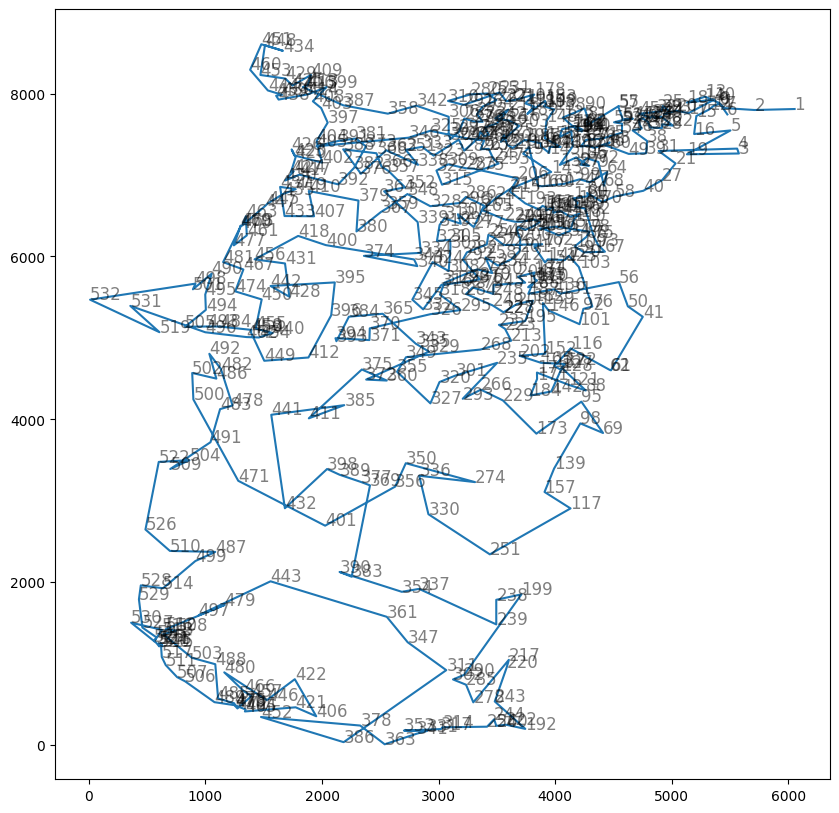

In [ ]:
for i in range(10):
  results = tsp_solve('att532',att_distance,27686,move_method = "2-opt",initial_method= "greedy")
  tsp_save(results,'tsp_results')